# DPX Calibration

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import cPickle
import hickle
%matplotlib inline

# Support functions
import startupDPX as su
import plotToTtoTHL as pttt
import ToTtoEnergy as tte
import THLConversion as thlc

# Reload
reload(su), reload(pttt), reload(tte), reload(thlc)

(<module 'startupDPX' from 'startupDPX.pyc'>,
 <module 'plotToTtoTHL' from 'plotToTtoTHL.pyc'>,
 <module 'ToTtoEnergy' from 'ToTtoEnergy.pyc'>,
 <module 'THLConversion' from 'THLConversion.pyc'>)

## Input files

In [3]:
ToTDir = 'Measurements'
# ToTfnList = [ToTDir + '/ToTMeasurement_AmSn4.hck'] 
ToTfnList = ['%s/DPX6/ToTMeasurement_%s.p' % (ToTDir, f) for f in ['AmSn2']] # , 'AmSn2']]
ToTHistFn = 'histMeasurement_AmSn.hck'
SLOT = 2
# ToTtoTHLfn = 'ToTtoTHL/DPX6/ToTtoTHL_5.hck'
ToTtoTHLfn = 'ToTtoTHL/DPX22/ToTtoTHL_DPX22_2.hck'
# ToTtoTHLfn = 'ToTtoTHL_14.p'

## Convert ToT to THL

plotToTtoTHL.py:38: RuntimeWarning: invalid value encountered in greater
  THLErr[THLErr > 100] = np.nan
plotToTtoTHL.py:133: RuntimeWarning: divide by zero encountered in divide
  res = np.where(x < b, a*(x - b) - c * (np.pi / 2 + t / (x - b)), 0)
plotToTtoTHL.py:72: RuntimeWarning: invalid value encountered in less_equal
  filtCond = THL_ <= 3000 # abs(THL_ - meanTHL) <= 3 * stdTHL


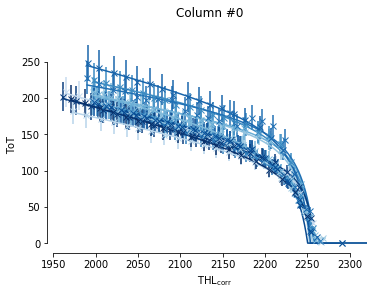

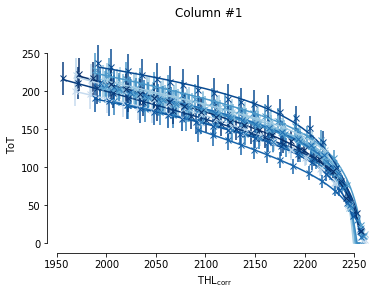

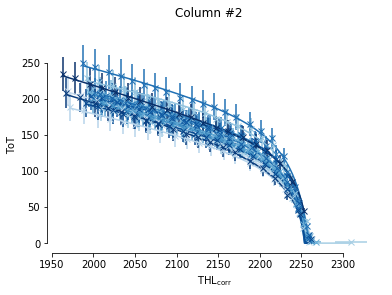

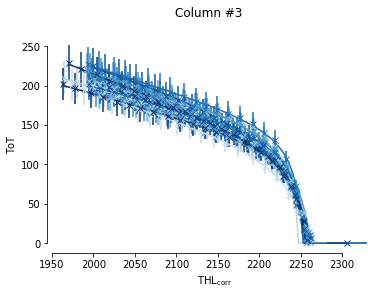

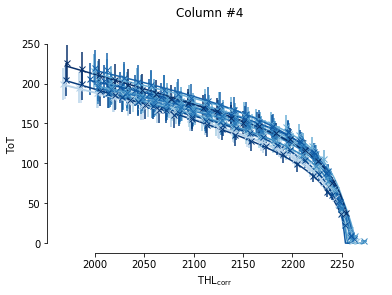

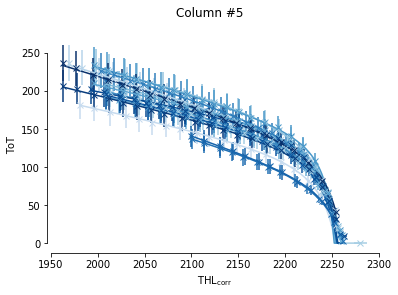

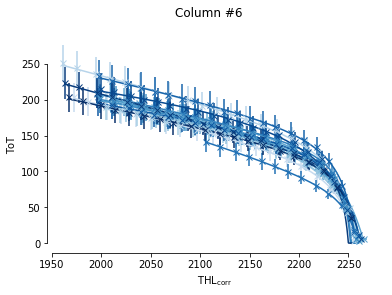

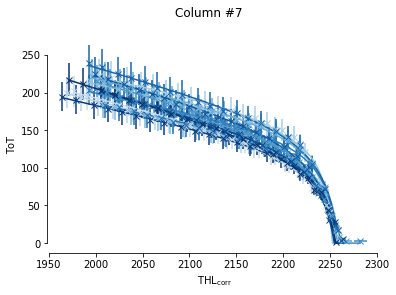

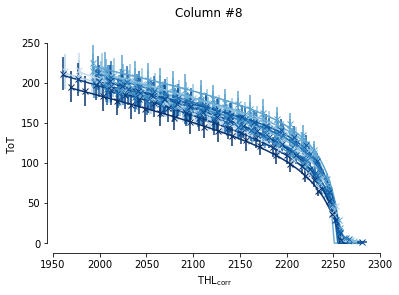

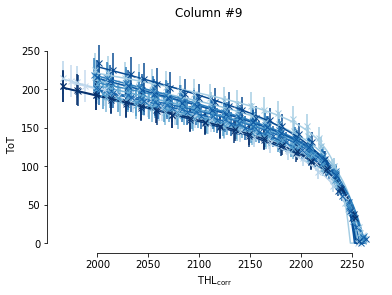

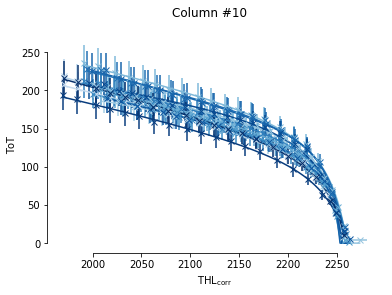

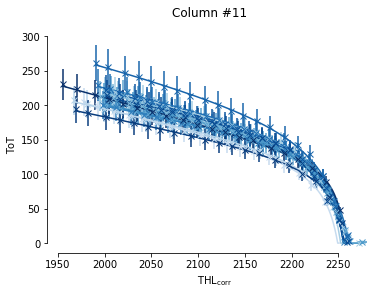

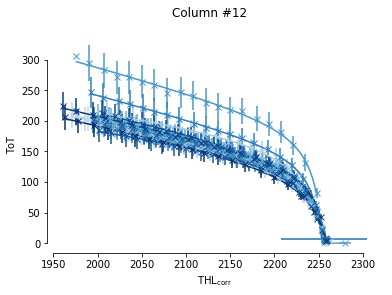

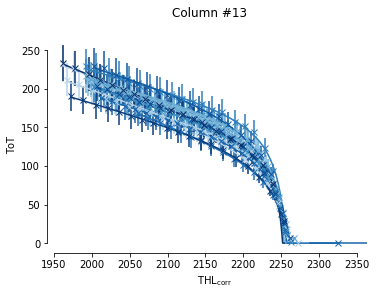

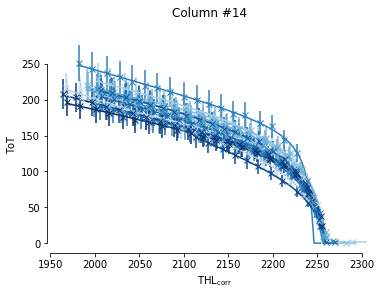

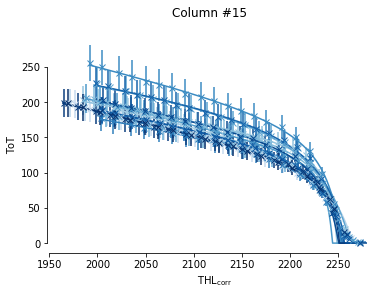

In [4]:
reload(pttt)

# Load dictionary
if '.p' in ToTtoTHLfn:
    d = cPickle.load( open(ToTtoTHLfn, 'rb') )
else:
    d = hickle.load(ToTtoTHLfn)
    
dOut = pttt.plotToTtoTHL(d)
# pttt.plotToTtoTHL(d, convDict=paramsDict)

## Load Spectrum

In [ ]:
dataList = [np.asarray( cPickle.load(open(ToTfn, 'r'))['Slot%d' % 2] ).T for ToTfn in ToTfnList]

In [ ]:
# Combine the data
data = np.hstack(dataList)
len(data), len(dataList[0])

## Convert data to histogram
Idea: Store data in ToT measurements in separate hickle files, containing a certain number of frames each. Afterwards, load them one after another and calculate the histogram for each file. Later, combine these histograms to get the data for the whole dataset. Therefore, the memory requirement is reduced drastically.

In [5]:
def dataToHist(data):
    histDict = {'bins': [], 'hist': []}
    for d in data:
        d = np.asarray(d)
        d = d[d > 0]
        try:
            hist, bins = np.histogram(d, bins=(max(d) - min(d)))
            histDict['bins'].append(bins), histDict['hist'].append(hist)
        except:
            hist, bins = None, None
            pass
        
    return histDict
    
# histDict = dataToHist(data)
histDict = hickle.load('Measurements/DPX22/AmMo_DPX22_complete.hck')
# hickle.dump(histDict, open(ToTDir + '/ToTMeasurementHist_AmSn4.hck', 'w'))

## Convert multiple files to histogram

In [3]:
def dirToHist(directory, slot=1):
    cnt = 50
    startTime = time.time()
    binsTot, histTot = [np.arange(4097)]*256, np.zeros((256, 4096))
    for c, fn in enumerate(os.listdir(directory)):
        print c
        # if c > cnt:
        #    break
            
        if fn.endswith('.hck'):
            data = hickle.load(directory + '/' + fn)
        elif fn.endswith('.p'):
            data = cPickle.load(open(directory + '/' + fn), 'rb')
        else:
            continue
    
        for i in range(256):
            pixelData = np.asarray(data['Slot%d' % slot])[:,i]
            
            # Filter empty entries
            pixelData = pixelData[pixelData > 0]
            
            hist, bins = np.histogram(pixelData, bins=binsTot[i])
            histTot[i] += hist
            
        print 'Estimated time: %.2f min' % (((time.time() - startTime) / (c + 1) * (cnt - c)) / 60)
            
    # for i in range(256):
    #    bins, hist = binsTot[i], histTot[i]
    #    bins[:-1] = bins[:-1][hist > 0]
    #    hist = hist[hist > 0]
        
    return {'bins': binsTot, 'hist': histTot}
    
testDict = dirToHist('/media/solvalou/58B9EB601FC22312/DPX22/ToTMeasurement_AmMo_DPX22')

0
Estimated time: 55.75 min
1
Estimated time: 55.07 min
2
Estimated time: 56.95 min
3
Estimated time: 56.57 min
4
Estimated time: 55.48 min
5
Estimated time: 54.71 min
6
Estimated time: 54.09 min
7
Estimated time: 52.70 min
8
Estimated time: 50.89 min
9
Estimated time: 49.22 min
10
Estimated time: 47.66 min
11
Estimated time: 46.16 min
12
Estimated time: 44.73 min
13
Estimated time: 43.59 min
14
Estimated time: 42.29 min
15
Estimated time: 41.03 min
16
Estimated time: 39.92 min
17
Estimated time: 38.77 min
18
Estimated time: 37.54 min
19
Estimated time: 36.30 min
20
Estimated time: 35.05 min
21
Estimated time: 33.80 min
22
Estimated time: 32.57 min
23
Estimated time: 31.36 min
24
Estimated time: 30.15 min
25
Estimated time: 28.95 min
26
Estimated time: 27.74 min
27
Estimated time: 26.56 min
28
Estimated time: 25.38 min
29
Estimated time: 24.23 min
30
Estimated time: 23.05 min
31
Estimated time: 21.88 min
32
Estimated time: 20.71 min
33
Estimated time: 19.54 min
34
Estimated time: 18.38

In [4]:
hickle.dump(testDict, open('AmMo_DPX22_complete.hck', 'w'))

## Load histograms from file

In [ ]:
histDict = hickle.load(ToTDir + '/DPX6/%s' % ToTHistFn)

## Show examples

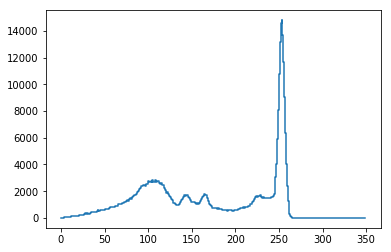

In [18]:
idx = 7
bins, hist = histDict['bins'][idx], histDict['hist'][idx]
hist = hist[bins[:-1] < 350]
bins = bins[bins < 350]

plt.step(bins, hist, where='post')
plt.show()

## Get conversion parameters for THL to energy

In [14]:
reload(thlc)
paramsDict = thlc.THLConversion(histDict, dOut, plot=False, use_hist=True)

{'a': -0.24486662350814803, 'c': -84.91872700745763, 'b': 2280.160025564101, 't': 39.2443452226789}
[2220.6177185046054, 2108.5279284763637, 1792.3758882713337] [2106.909090909096, 1679.1258741258782, 14177.52913752917]
[2216.8511929181486, 2104.936946589593, 1696.418341810388] [3231.23776223777, 1654.9766899766942, 13117.442890442922]
[2210.877392861881, 2103.912560547209, 1773.139419743098] [2305.680652680658, 1570.8414918414956, 13025.813519813551]
[2216.644832752084, 2102.5848063391604, 1676.1029671402323] [3476.757575757584, 1718.6969696969736, 13289.46153846157]
[2210.830078695867, 2095.537732530745, 1740.5970607811746] [2897.5058275058345, 1708.939393939398, 14100.230769230802]
[2209.5778257960014, 2095.490485957184, 1756.4244640111076] [2761.6899766899833, 1726.592074592079, 14109.836829836864]
[2218.1048936549164, 2124.502011514682, 1739.2451285830593] [3275.6177156177237, 1524.580419580423, 12380.571095571126]
[2216.387141404683, 2099.7970980065566, 1788.1119324496708] [2449.

## ToT to Energy
Use found conversion parameters on data

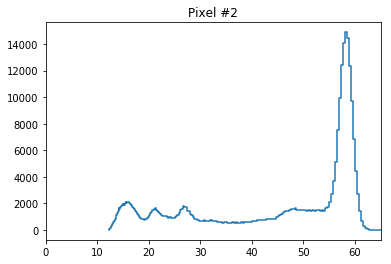

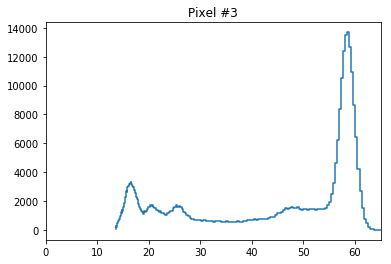

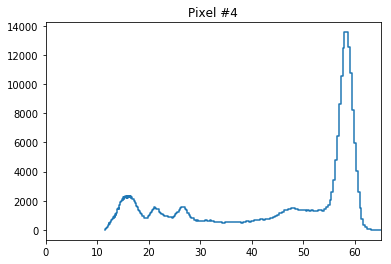

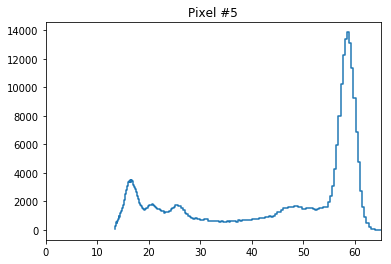

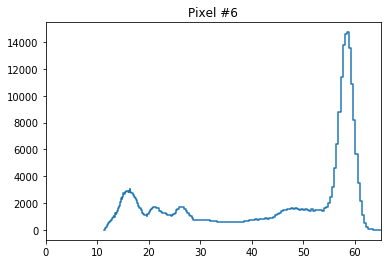

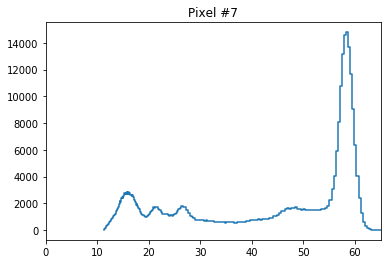

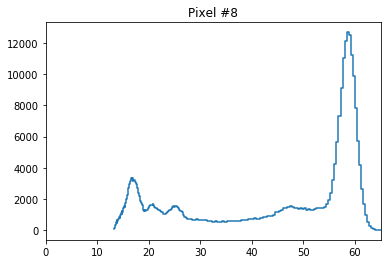

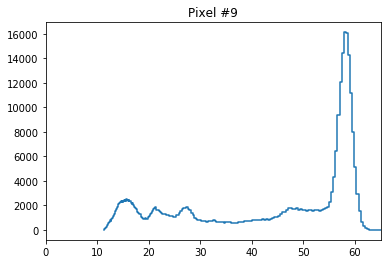

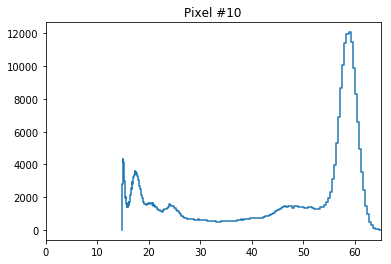

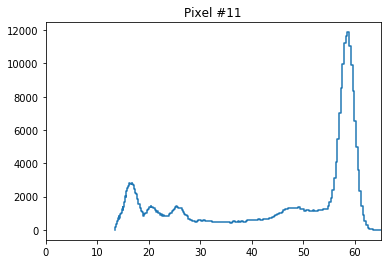

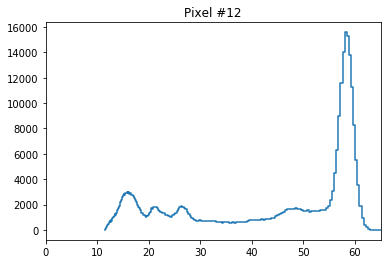

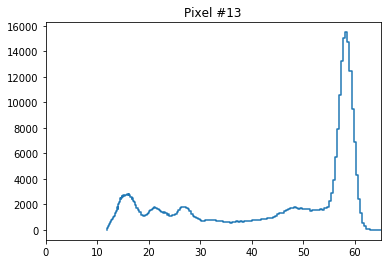

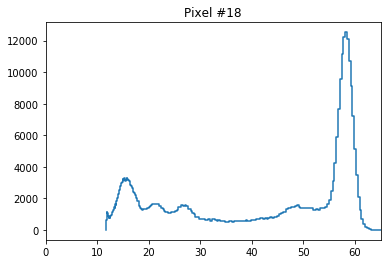

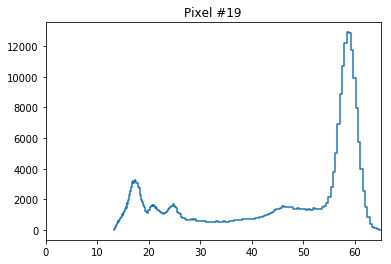

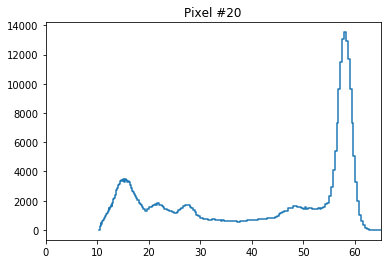

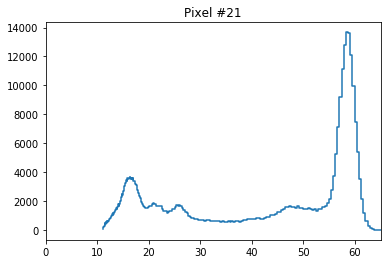

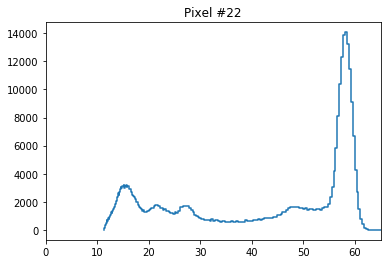

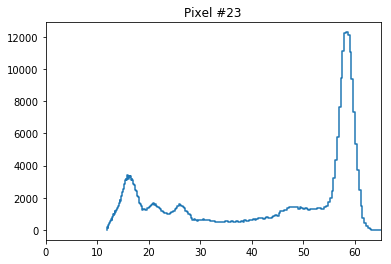

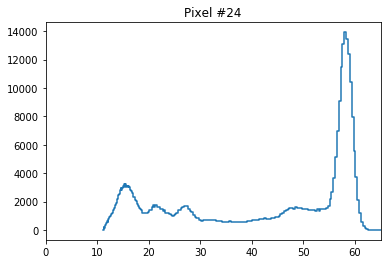

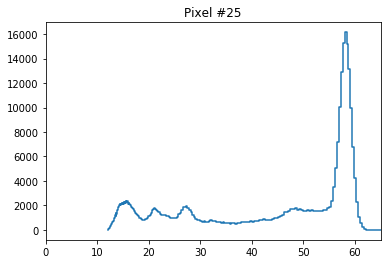

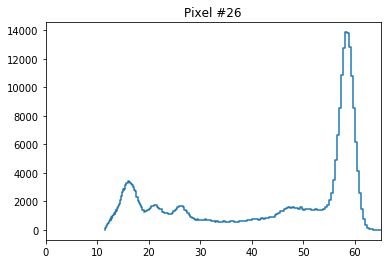

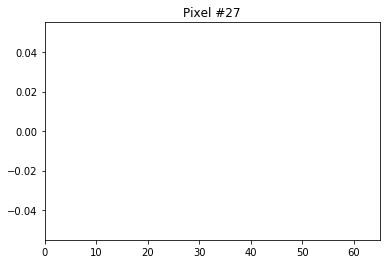

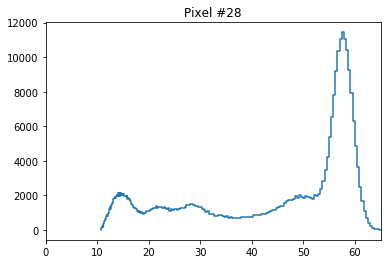

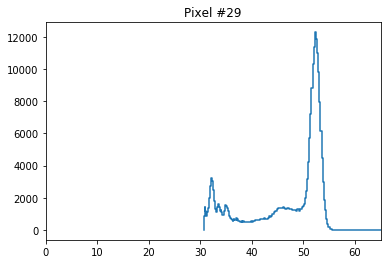

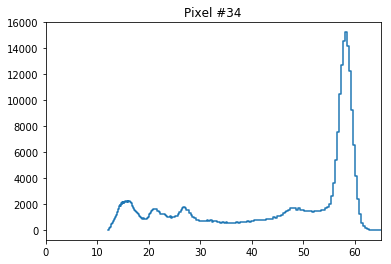

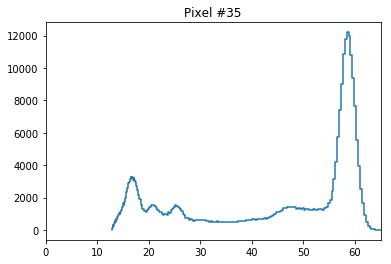

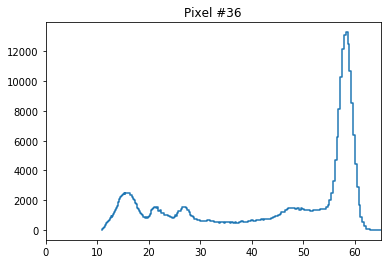

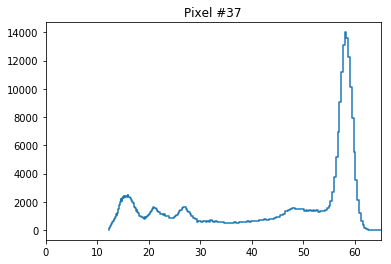

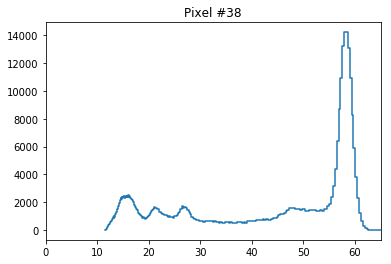

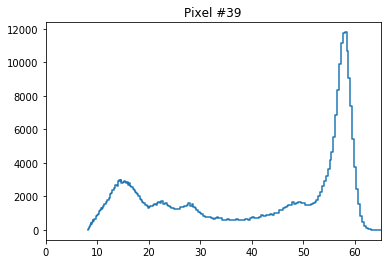

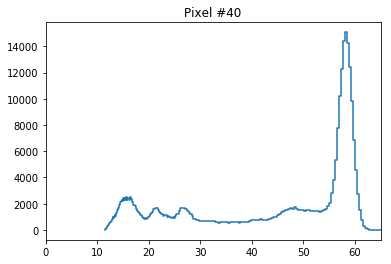

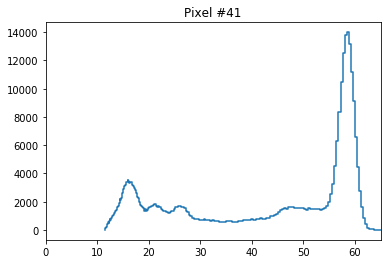

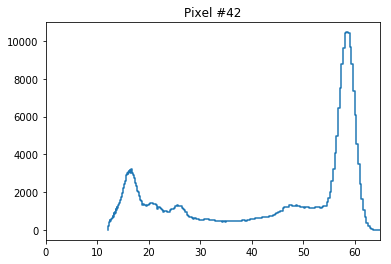

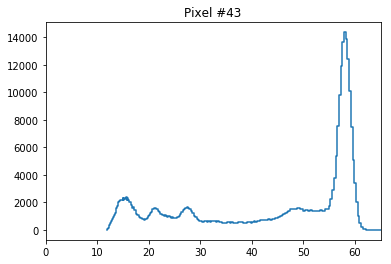

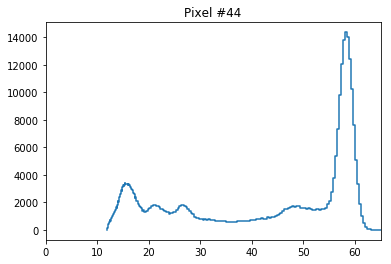

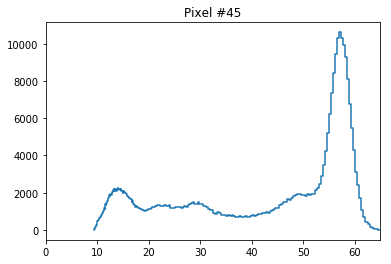

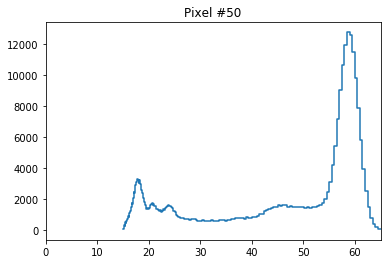

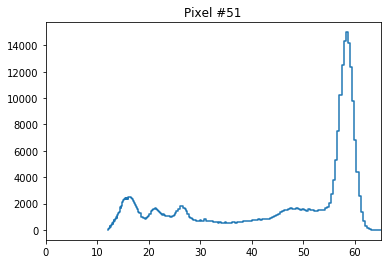

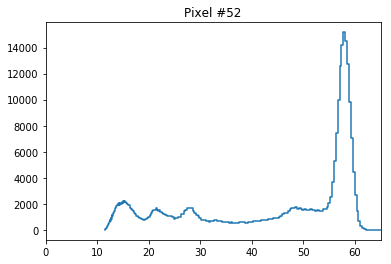

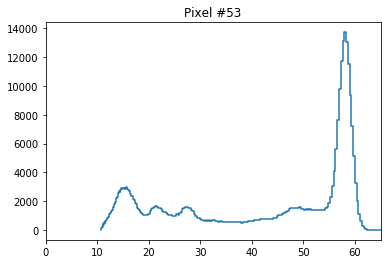

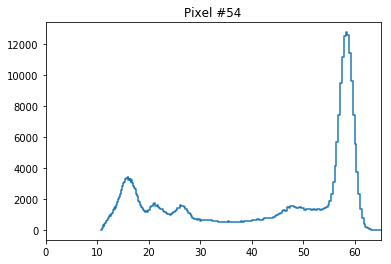

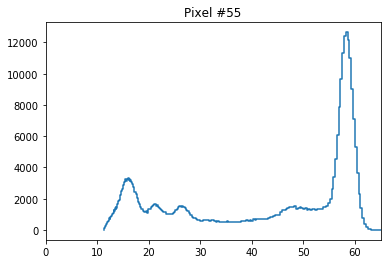

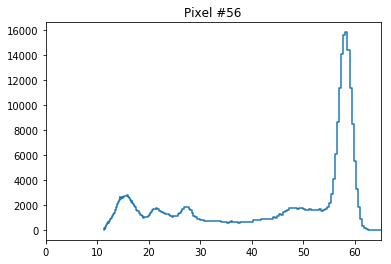

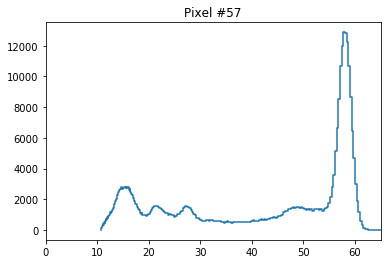

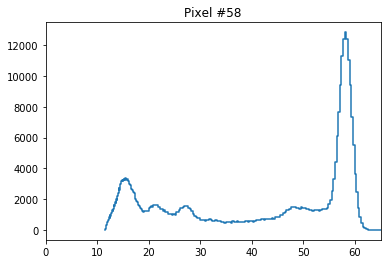

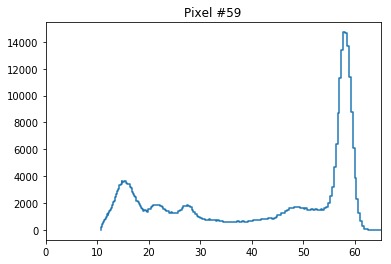

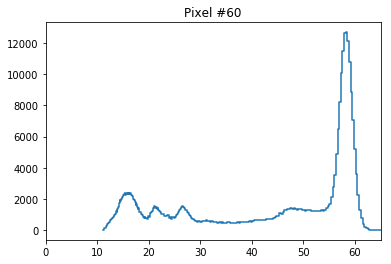

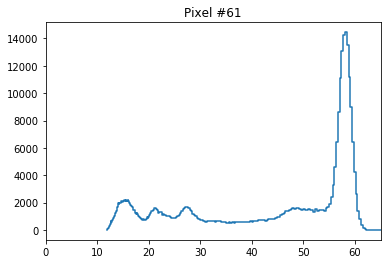

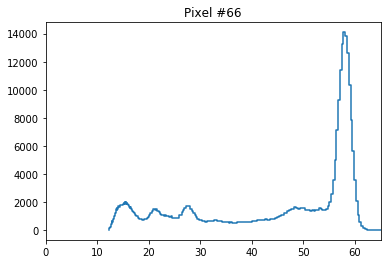

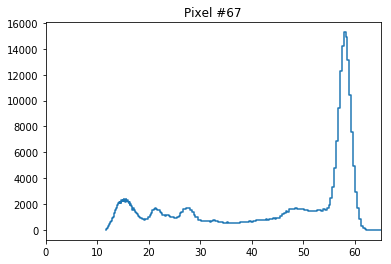

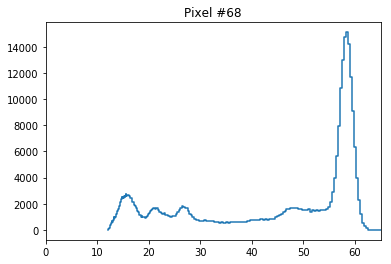

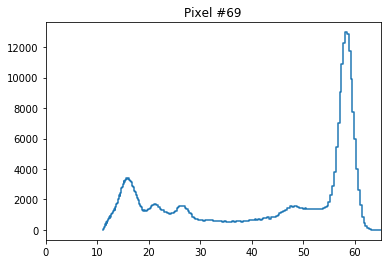

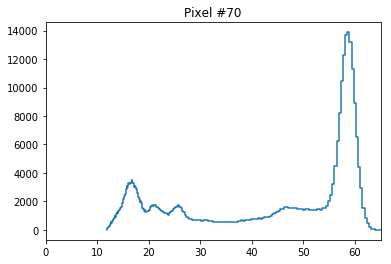

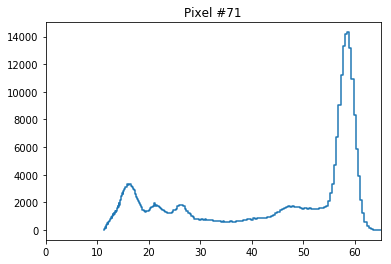

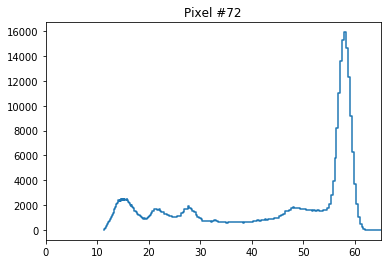

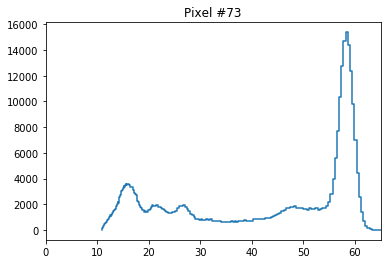

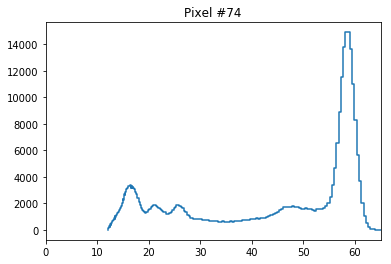

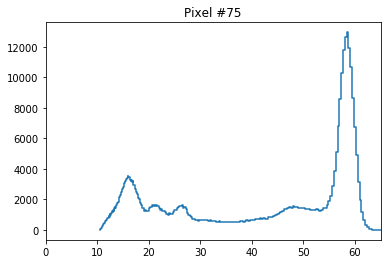

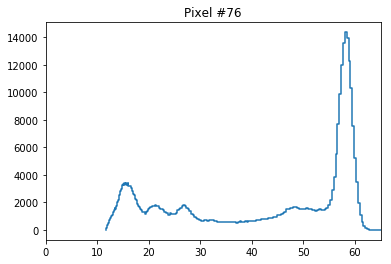

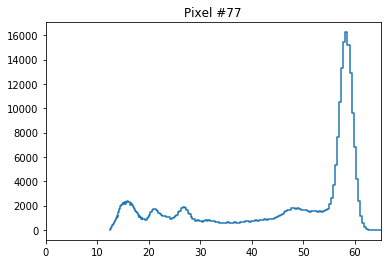

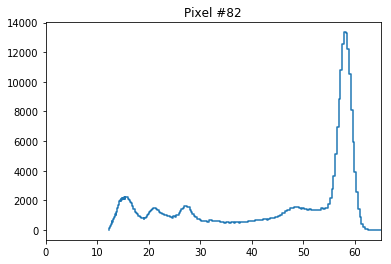

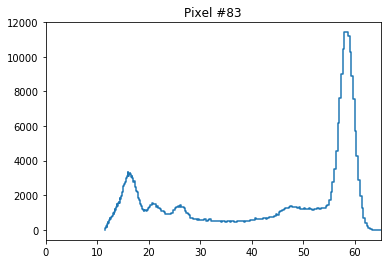

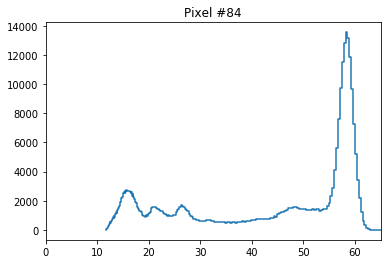

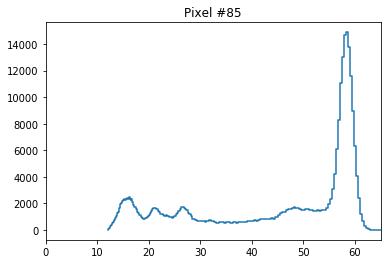

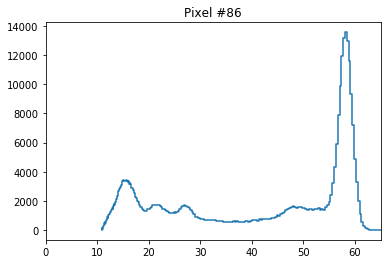

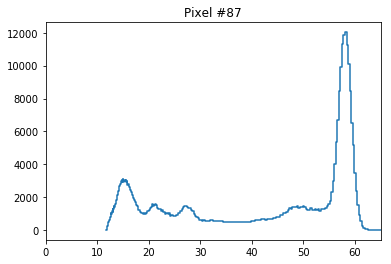

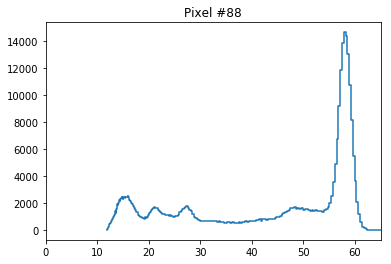

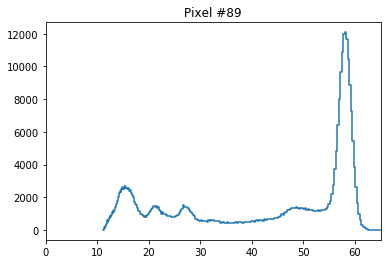

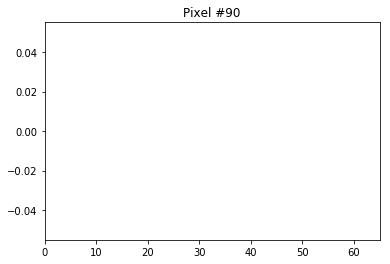

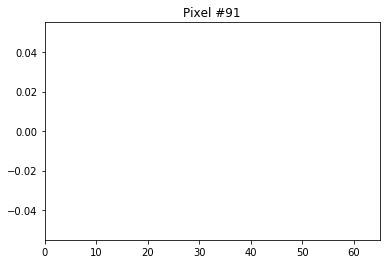

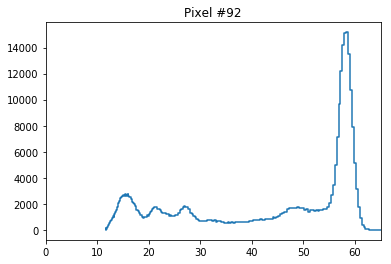

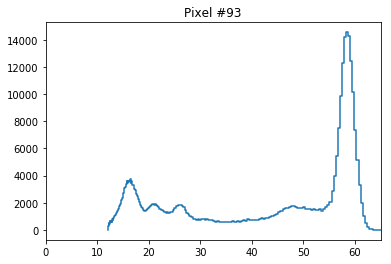

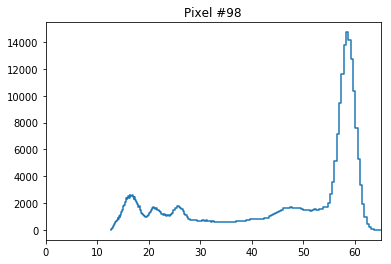

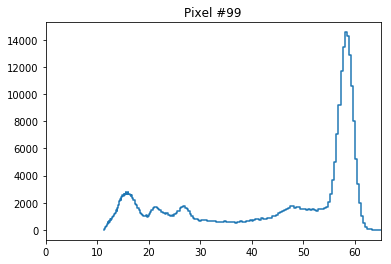

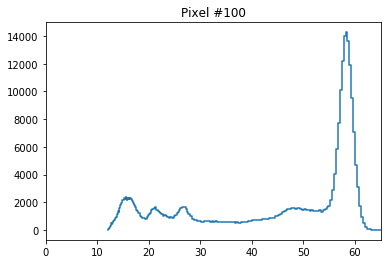

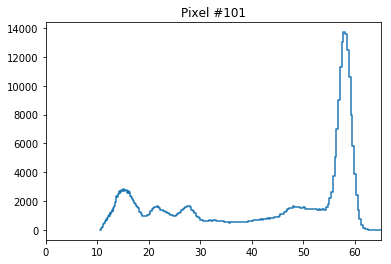

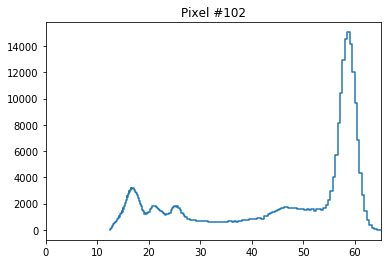

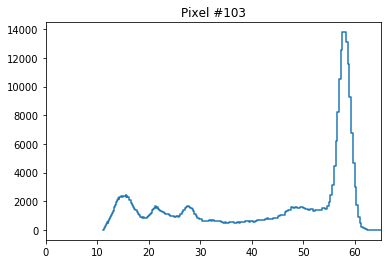

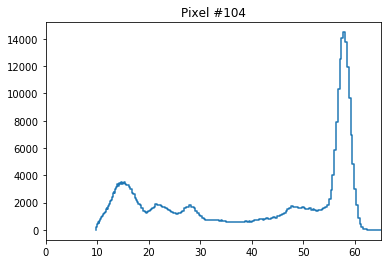

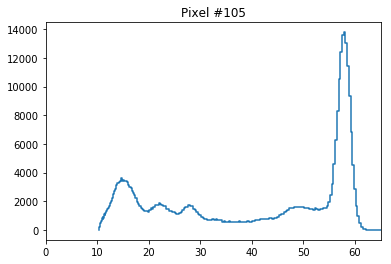

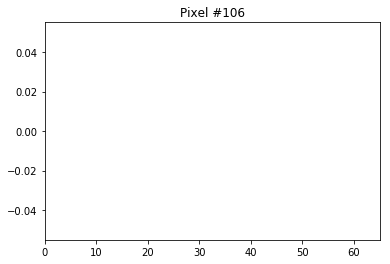

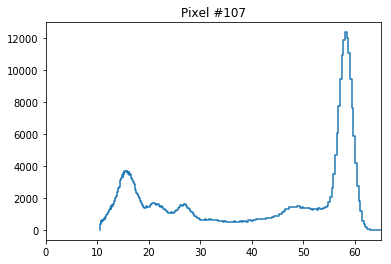

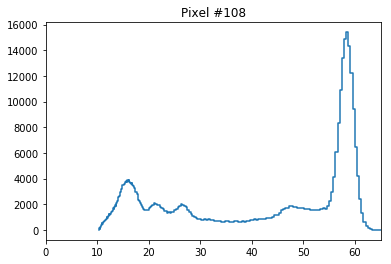

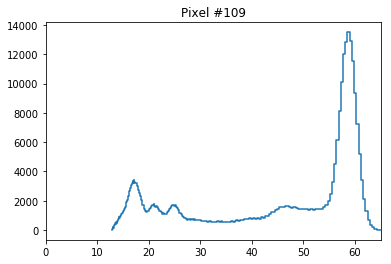

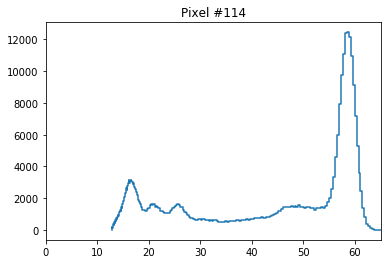

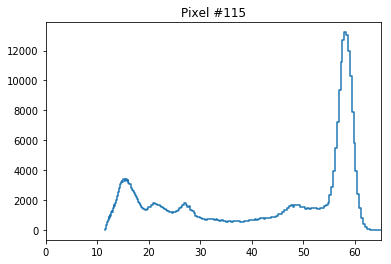

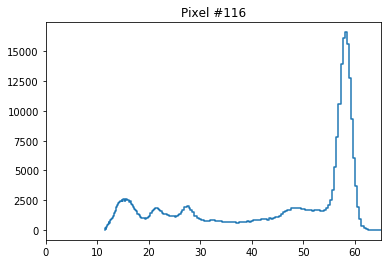

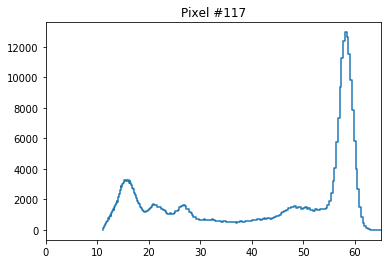

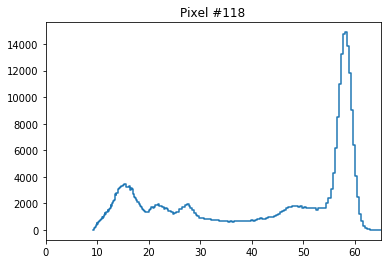

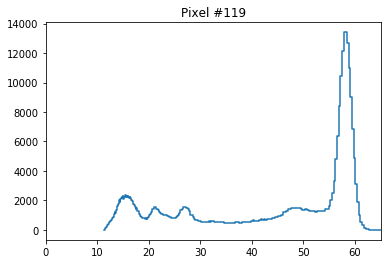

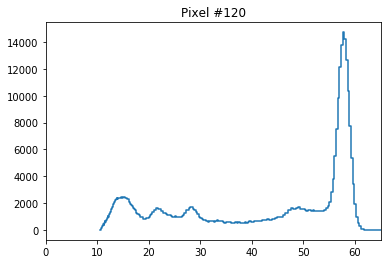

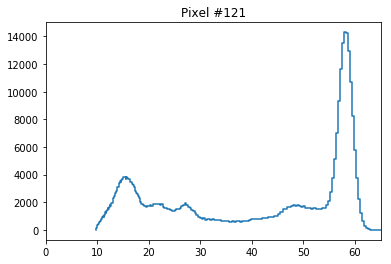

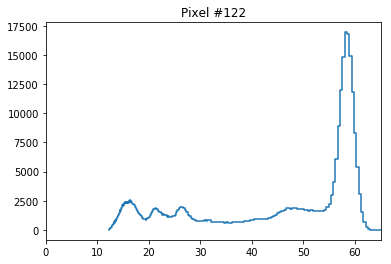

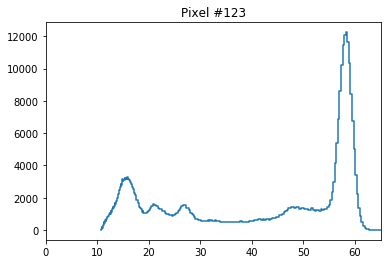

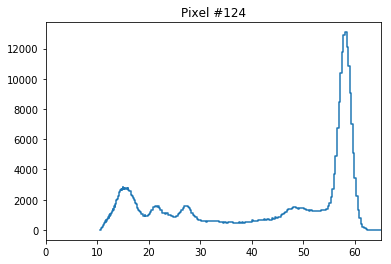

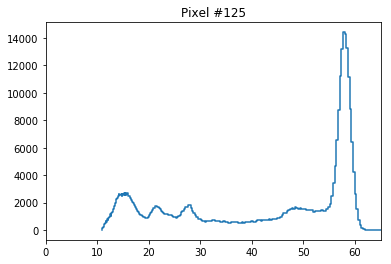

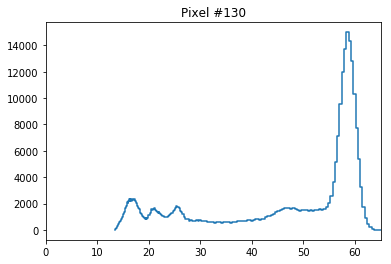

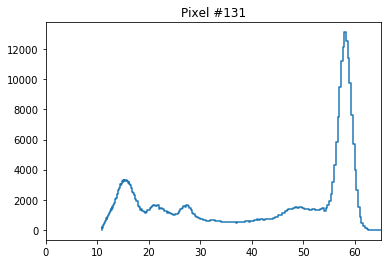

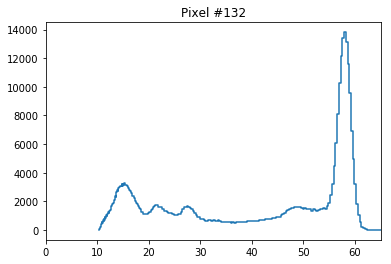

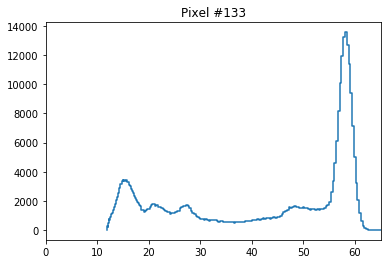

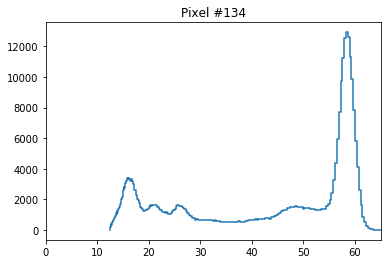

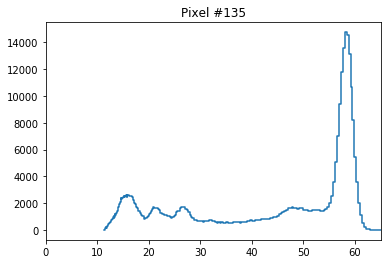

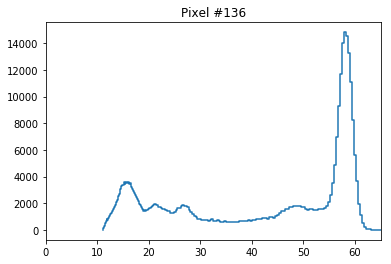

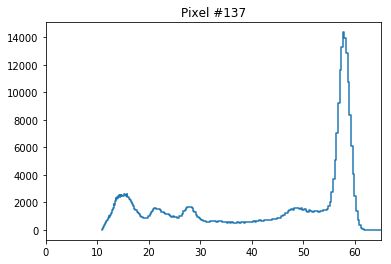

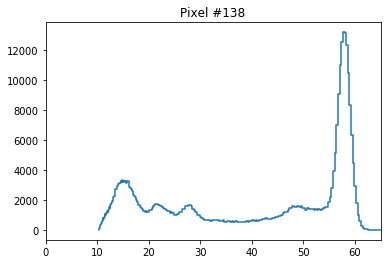

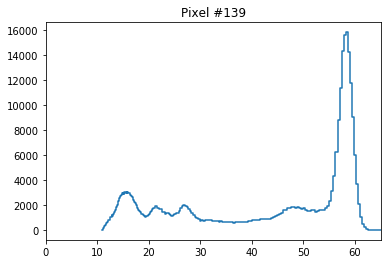

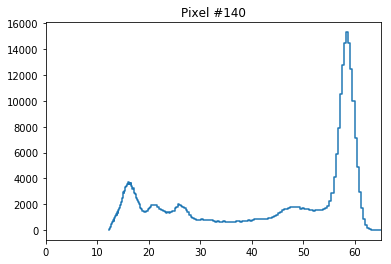

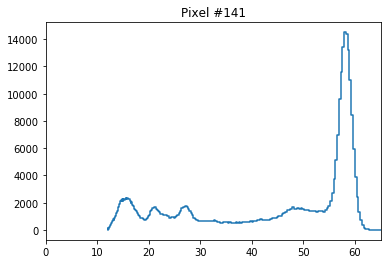

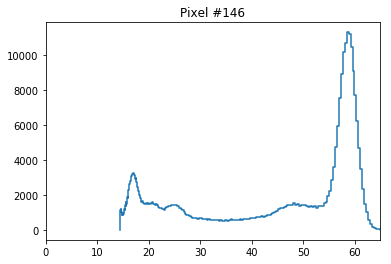

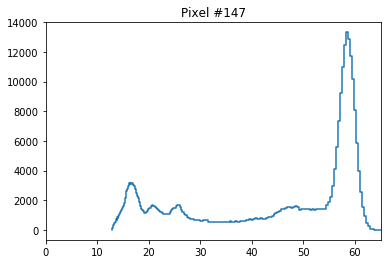

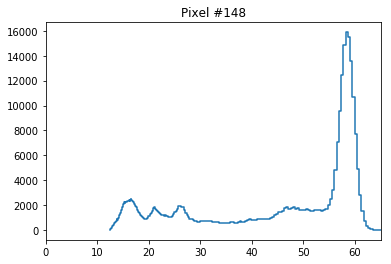

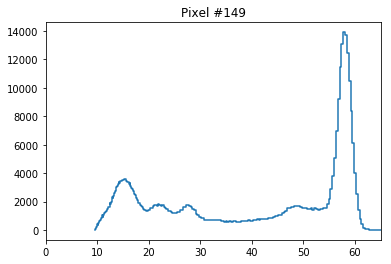

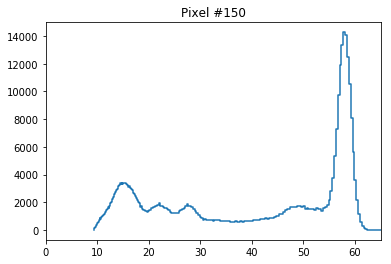

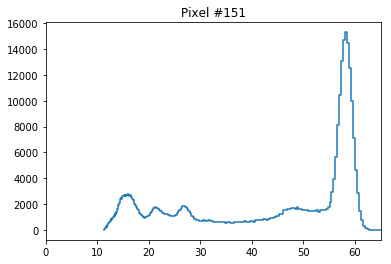

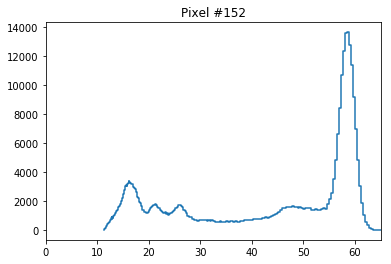

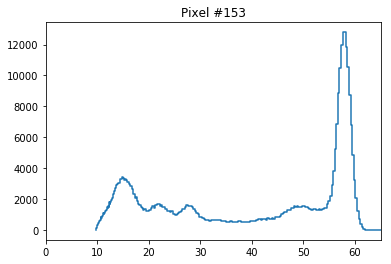

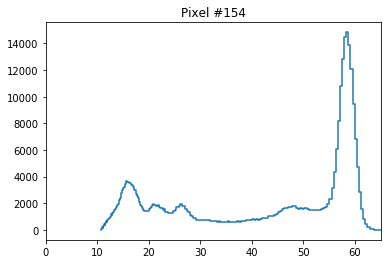

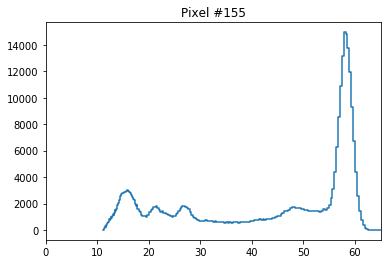

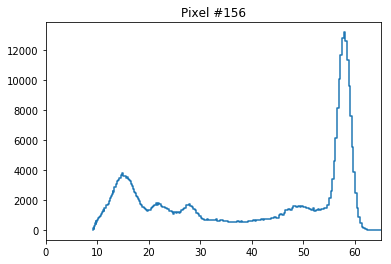

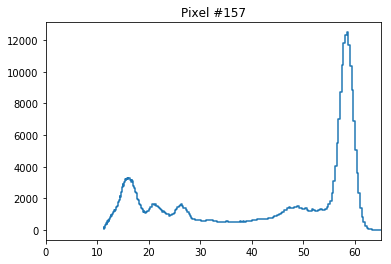

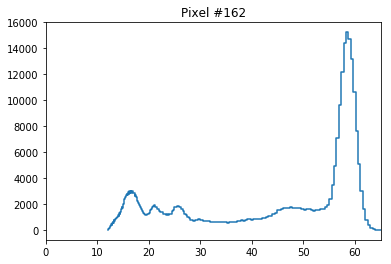

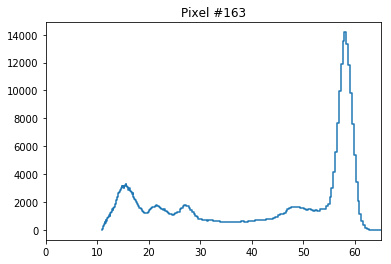

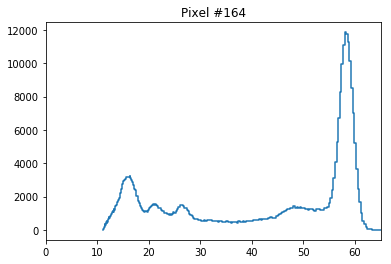

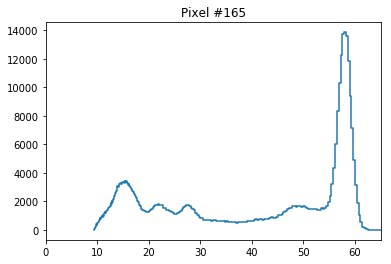

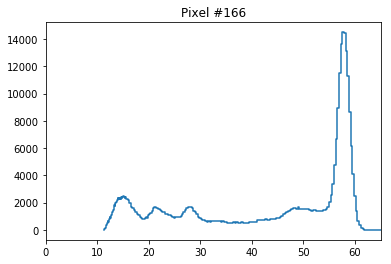

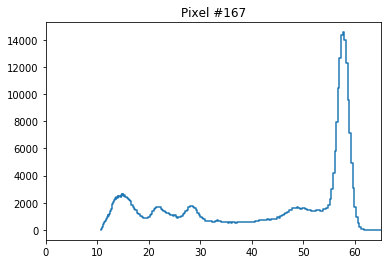

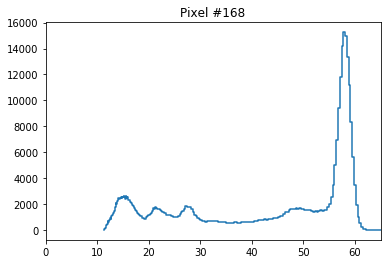

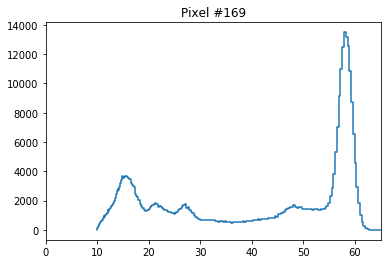

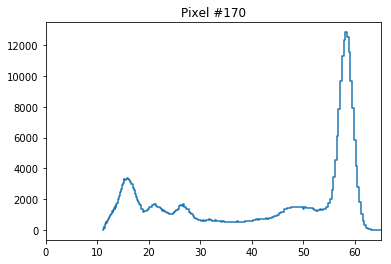

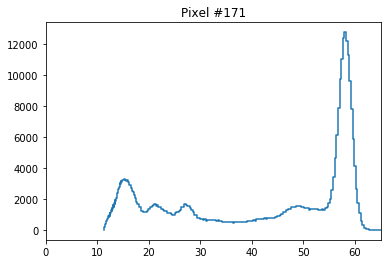

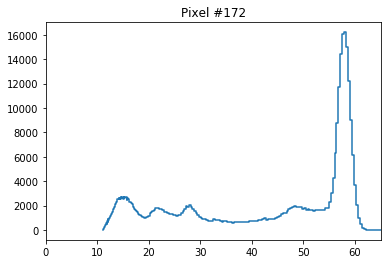

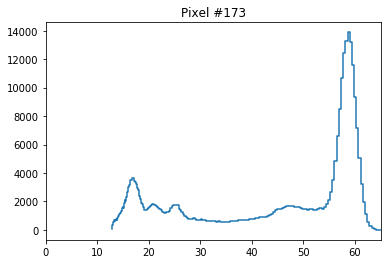

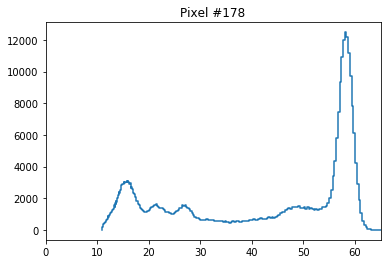

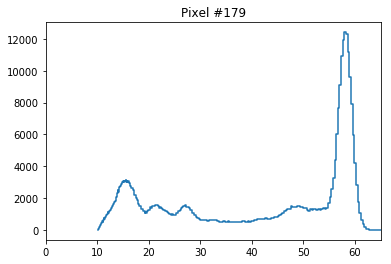

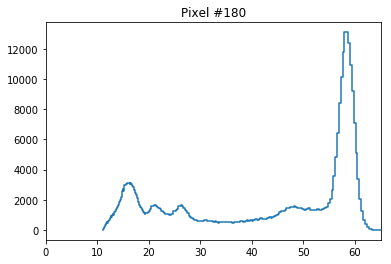

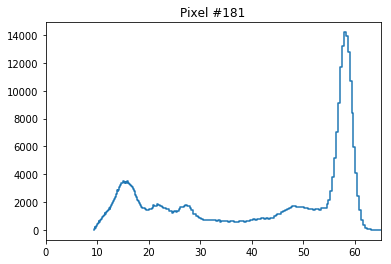

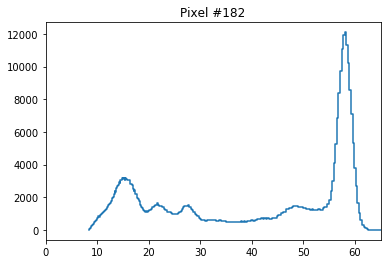

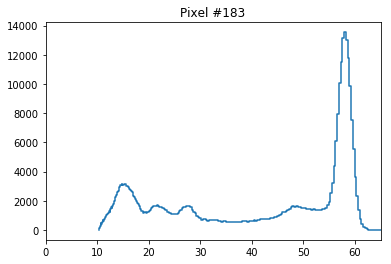

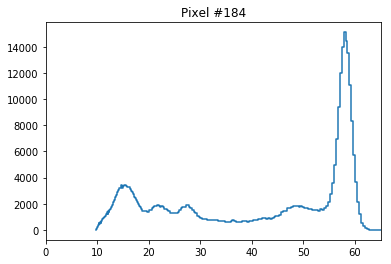

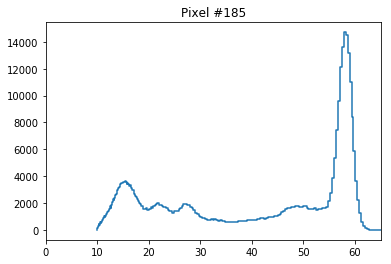

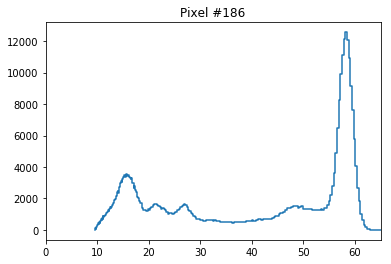

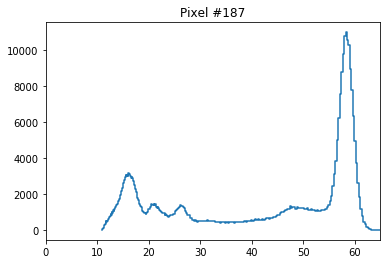

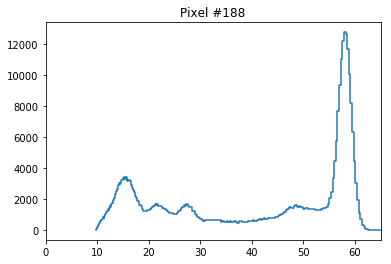

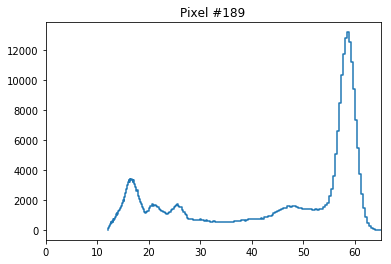

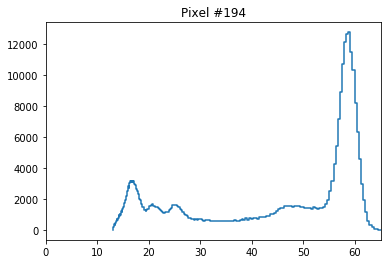

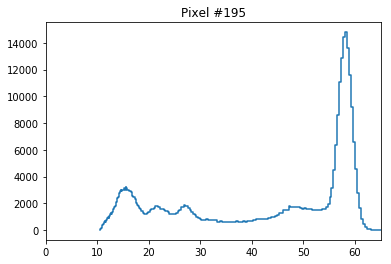

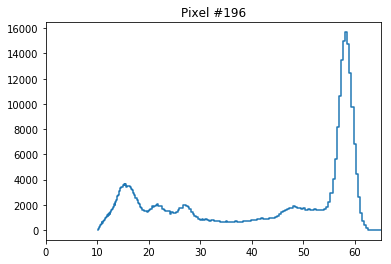

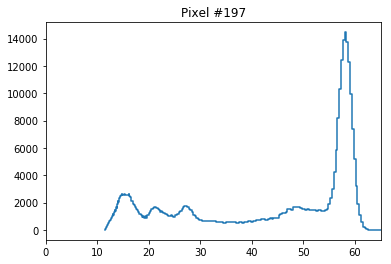

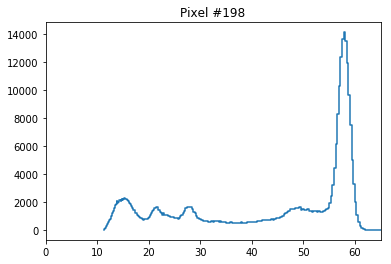

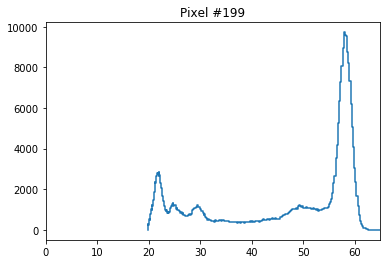

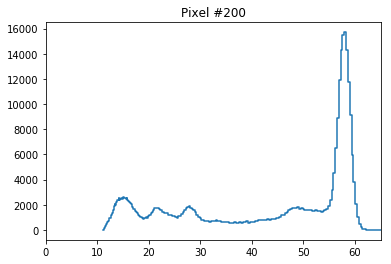

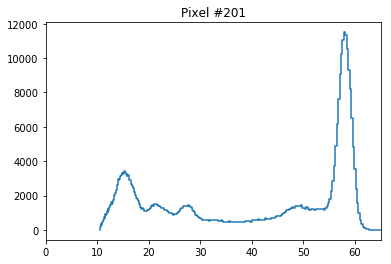

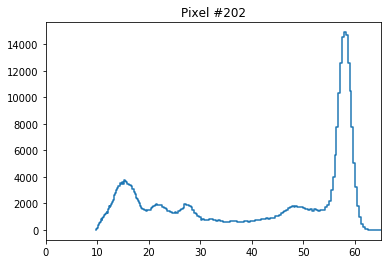

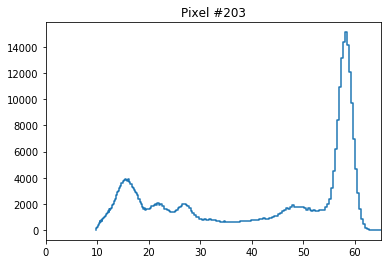

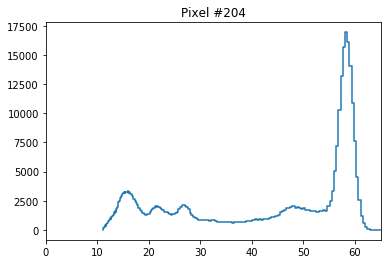

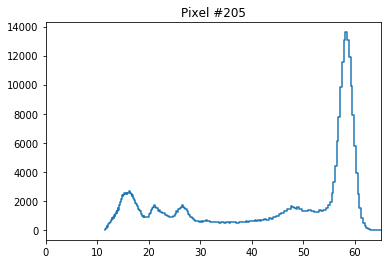

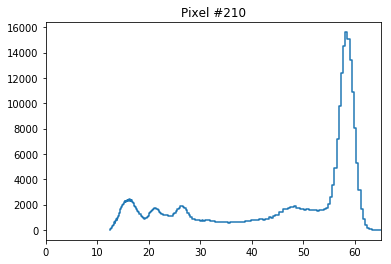

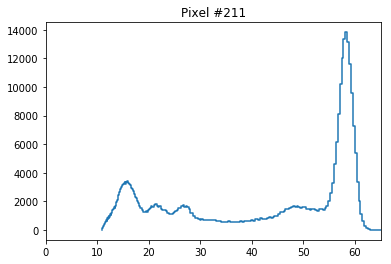

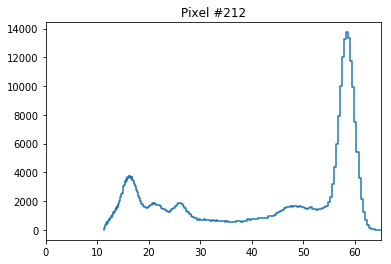

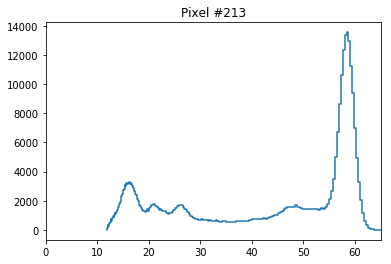

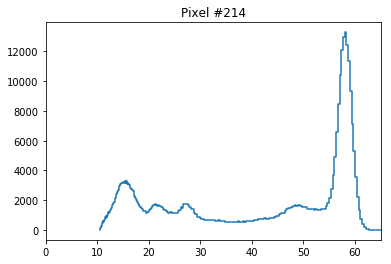

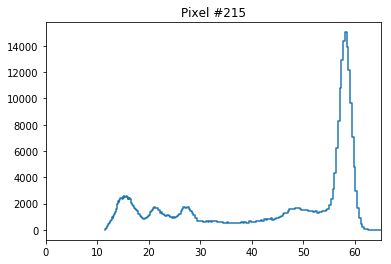

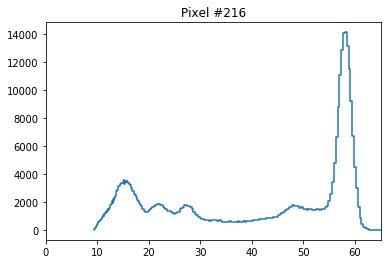

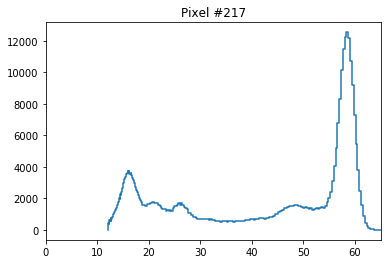

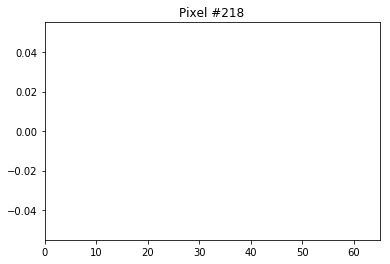

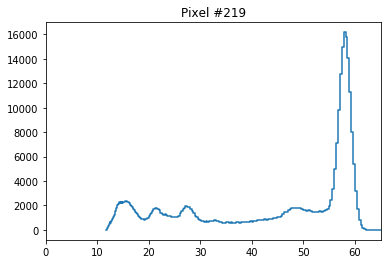

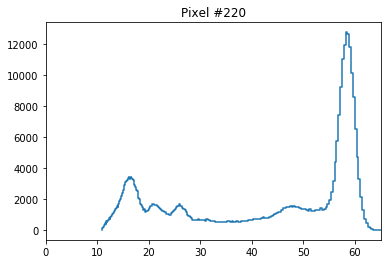

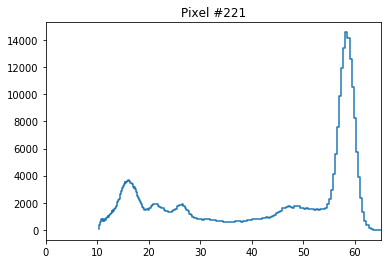

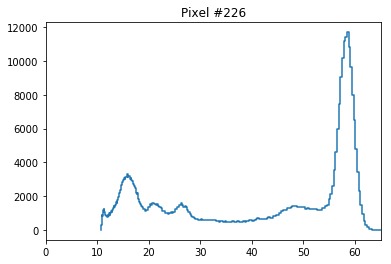

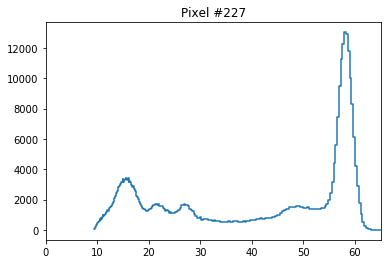

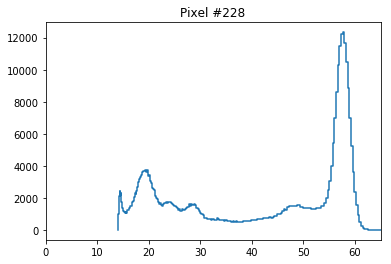

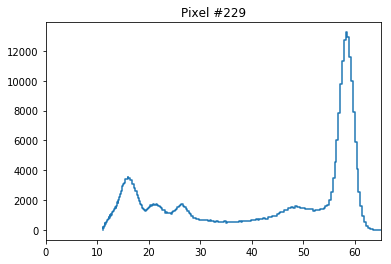

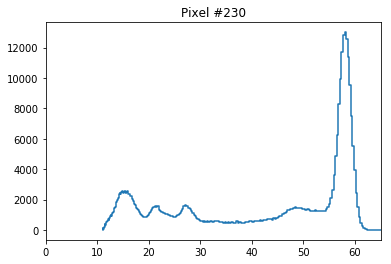

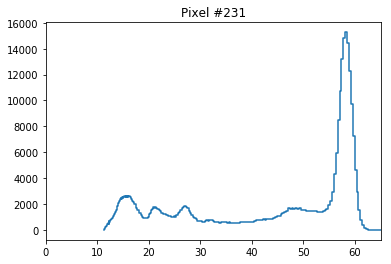

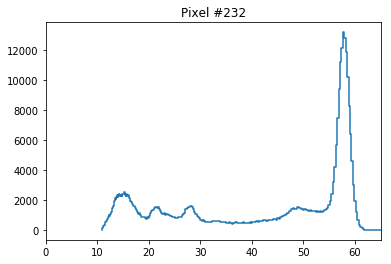

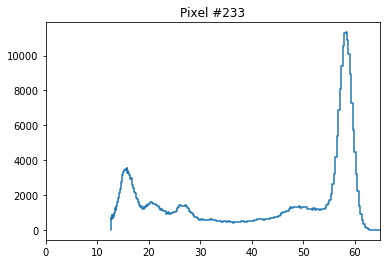

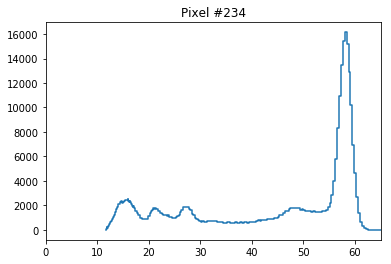

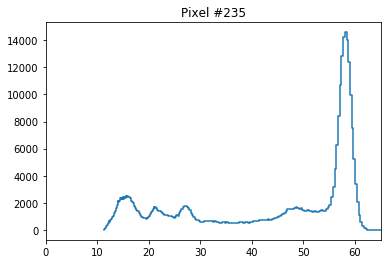

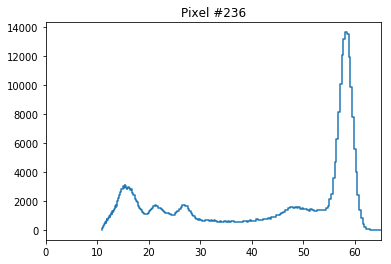

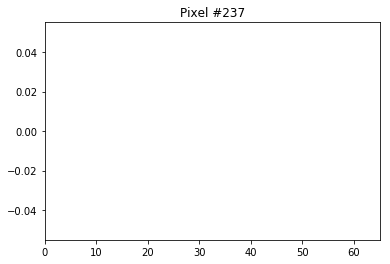

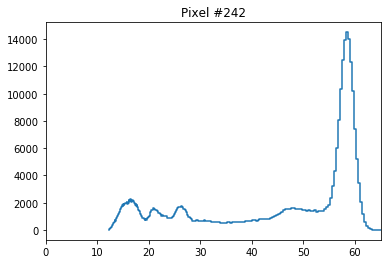

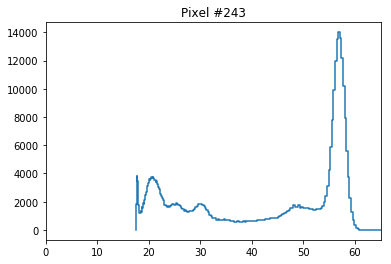

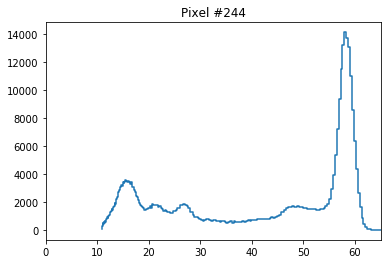

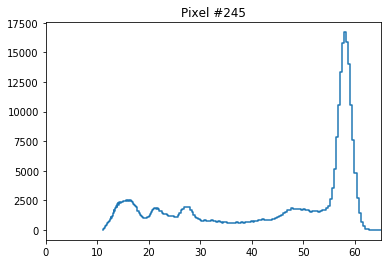

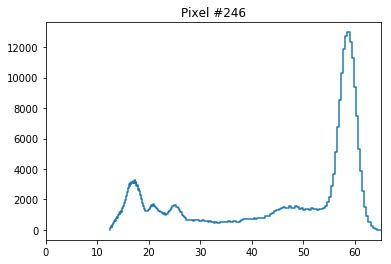

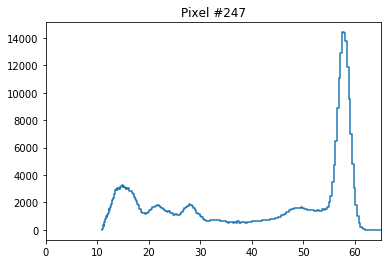

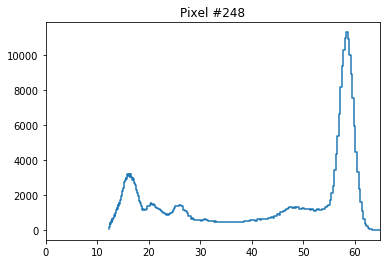

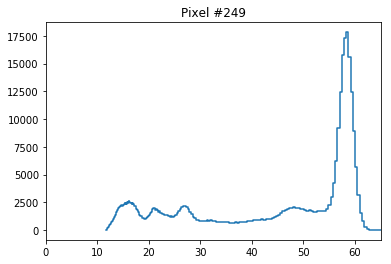

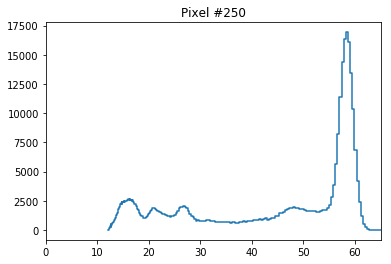

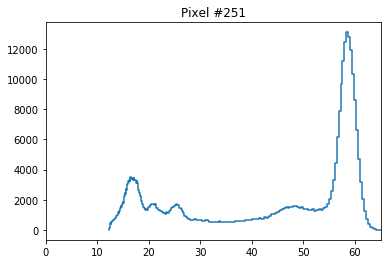

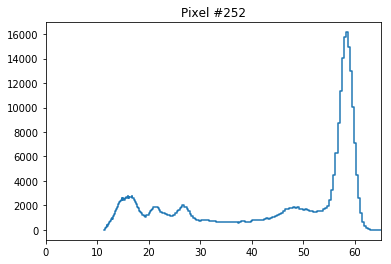

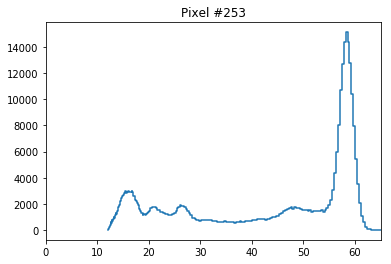

[ 12.29173947  12.30836303  12.30836303 ... 196.86955869 205.80387942
 220.95825452]


ToTtoEnergy.py:81: RuntimeWarning: invalid value encountered in greater
  totalData = totalData[np.logical_and(totalData > 0, totalData < 65)]
ToTtoEnergy.py:81: RuntimeWarning: invalid value encountered in less
  totalData = totalData[np.logical_and(totalData > 0, totalData < 65)]


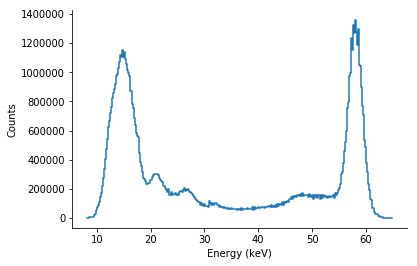

array([12.29173947, 12.30836303, 12.30836303, ..., 64.60033189,
       64.60033189, 64.60033189])

In [15]:
reload(tte)
tte.getToTtoEnergy(histDict, paramsDict, use_hist=True)

## Store to files

In [20]:
hickle.dump(paramsDict, open('energyConversion/paramsDict_DPX22.hck', 'w'))

{'a': -0.2164967954076204, 'c': -93.07962950756063, 'b': 2287.9539225680646, 'h': -0.09356953167888862, 'k': 222.6544402886111, 't': 47.30313834826713}
-0.2164967954076204 2287.9539225680646 -93.07962950756063 47.30313834826713
8.571663251041088
353.24566594731056
66.65312048881157


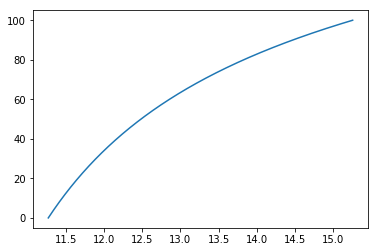

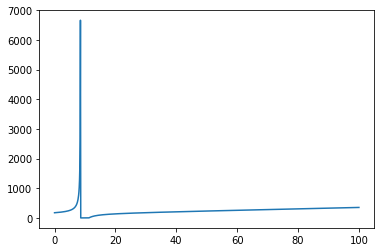

In [19]:
# cPickle.dump(paramsDict, open('testCalibFactors.p', 'wb'))
p = paramsDict[7]
a, b, c, t, h, k = p['a'], p['b'], p['c'], p['t'], p['h'], p['k']
print p
# a /= h
# b = b*h + k
# t *= h
print a, b, c, t

def ToTtoEnergySimple(x, a, b, c, t, h=1, k=0):
    return h * (b + 1./(4 * a) * (2*x + np.pi*c + np.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))) + k

def EnergyToToTSimple(x, a, b, c, t, h=1, k=0):
    res = np.where(x < b, a*((x - k)/h - b) - c * (np.pi / 2 + t / ((x - k)/h - b)), 0)
    res[res < 0] = 0
    return res

print(b*h + k)
print(EnergyToToTSimple(100, a, b, c, t, h, k))
print(ToTtoEnergySimple(273.5021034056356, a, b, c, t, h, k))

x = np.linspace(0, 100, 1000)
plt.plot(ToTtoEnergySimple(x, a, b, c, t, h, k), x)
plt.show()
plt.plot(x, EnergyToToTSimple(x, a, b, c, t, h, k))